In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
import seaborn as sns
sns.set()

random.seed(42)

class memory_cell():
    """
    Memory cell to store the impression of another agent is simply its defection rate
    
    Attributes
    ------------
    defect_number_ : Number of defection
    play_number_   : Number of Plays
    
    """
    def __init__(self, act = 'C'):
        self.defect_number_ = 0.0
        self.play_number_ = 1.0
        
        if act == 'D' : self.defect_number_ += 1.0
    
    def update(self, act):
        if act == 'D' : self.defect_number_ += 1.0
        self.play_number_ += 1.0
    
    def impression(self):
        return self.defect_number_/max(1.0, self.play_number_)
    
class agent():
    """
    Player of a Prisoners Dilemma Game. 
    
    Parameters
    ------------
    ID            : Unique identifier for the agent
    pd            : Probability of defection
    capacity      : Memory Size/Capacity 
    
        
    Attributes
    ------------
    score_                  : Accumulates payoffs (define success/fitness)
    memory_for_defectors_   : 
    memory_for_cooperators_ :
                 Store information about a limited number (M) of opponent players.
                 Dictionary (key, value) = (other_agent, memory_cell)
    
    """
    def __init__(self, ID, pd = 1, M = 1):
        self.ID = ID
        self.pd = pd
        self.capacity = M
        self.score_ = 0
        
        self.memory_for_defectors_ = dict()
        self.memory_for_cooperators_ = dict()
        
    def act(self):
        """
        Two possible actions
            - defect with probability pd
            - cooperate with probability 1 - pd
        """
        if np.random.rand() < self.pd:
            return 'D'
        return 'C'
    
    def know(self, other):
        return (other in self.memory_for_defectors_) or (other in self.memory_for_cooperators_)
    
    def is_memory_full(self):
        c,d = len(self.memory_for_cooperators_), len(self.memory_for_defectors_)
        return  c + d >= self.capacity
    
    def perceive_as_defector(self, other):
        return other in self.memory_for_defectors_
    
    def take_payoff(self, payoff):
        self.score_ += payoff
    
    def learn(self, other, act):  
        if other in self.memory_for_defectors_:
            print("-- Bug -- Dont play with a defector!! -- ")
        elif other in self.memory_for_cooperators_:
            self.memory_for_cooperators_[other].update(act)
            
            # a cooperator became a defector!
            if self.memory_for_cooperators_[other].impression() > 0.5:
                self.memory_for_defectors_[other] = self.memory_for_cooperators_[other]
                del self.memory_for_cooperators_[other]
        else: # first play with an unknown player
            if self.is_memory_full(): 
                self.forget()
            if act == 'C':
                self.memory_for_cooperators_[other] = memory_cell(act)
            else:
                self.memory_for_defectors_[other] = memory_cell(act)
        
    def forget(self):   
        if len(self.memory_for_cooperators_) > 0:
            f = random.choice(list(self.memory_for_cooperators_.keys()))
            del self.memory_for_cooperators_[f]
        else:
            f = random.choice(list(self.memory_for_defectors_.keys()))
            del self.memory_for_defectors_[f]

    def display(self):
        return [(k.ID, v.impression()) for (k,v) in self.memory_for_cooperators_.items()] + [(k.ID, v.impression()) for (k,v) in self.memory_for_defectors_.items()]
    
    

In [2]:
class abm():
    def __init__(self, N = 10, M = 9, tau = 30, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [agent(i, pd = np.random.rand(), M = M) for i in range(self.N)]
        self.payoff = payoff
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.take_payoff(self.payoff[A_action+B_action])
            B.take_payoff(self.payoff[B_action+A_action])
            
    def display(self):
        df = pd.DataFrame(columns=['ID','pD', 'score', 'M', 'Memory Len', 'Memory'])
        for A in self.population:
            df.loc[A.ID] = pd.Series({'ID':A.ID, 'pD':A.pd, 'score':A.score_, 'M': A.capacity, 
                                      'Memory Len': len(A.memory_for_cooperators_) + len(A.memory_for_defectors_), 
                                      'Memory':A.display()})
        return df

# Simulation

In [3]:
N = 100
M = 50
sim = abm(N, M)
sim.world()
result = sim.display()
result.head(3)

,ID,pD,score,M,Memory Len,Memory
0,0,0.406874,1842,50,50,"[(54, 1.0), (27, 1.0), (79, 1.0), (76, 1.0), (..."
1,1,0.090942,3589,50,50,"[(16, 0.0), (49, 1.0), (0, 1.0), (70, 1.0), (3..."
2,2,0.048717,3900,50,50,"[(51, 0.0), (21, 1.0), (58, 1.0), (90, 1.0), (..."


In [5]:
#result

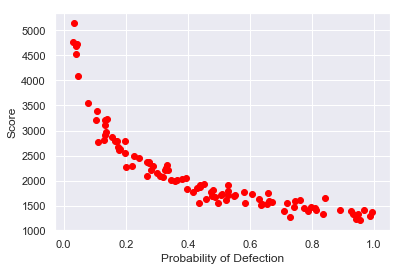

In [11]:
# Plot
plt.scatter(result.pD, result.score, color = 'red')
plt.xlabel('Probability of Defection');plt.ylabel('Score');

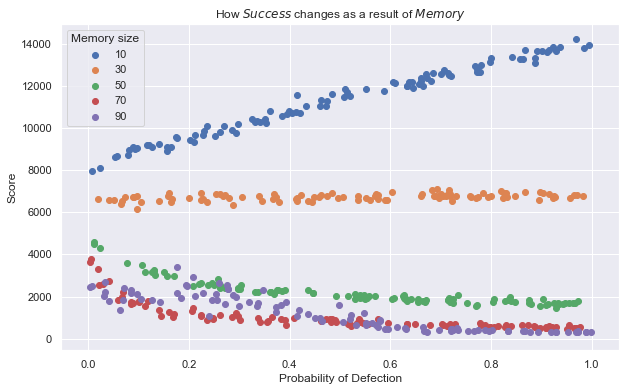

In [12]:
payoff_matrix = {'CC':3,'CD':0,'DC':5,'DD':1}
plt.figure(figsize = (10,6))
for m in [10,30,50,70, 90]:
    sim = abm(N = 100, M= m, payoff = payoff_matrix)
    sim.world()
    result = sim.display()
    plt.scatter(result.pD, result.score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("How $Success$ changes as a result of $Memory$")

# More Hostile Environment

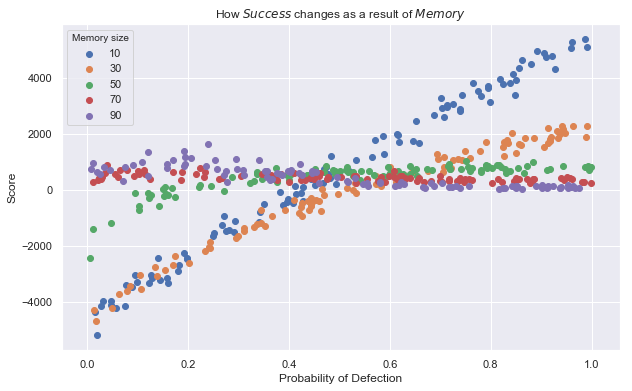

In [6]:
# CD: S, DD:P, S < P < R < T
payoff_matrix = {'CC':3,'CD':-5,'DC':5,'DD':-3}
plt.figure(figsize = (10,6))
for m in [10,30,50,70,90]:
    sim = abm(N = 100, M = m, payoff = payoff_matrix)
    sim.world()
    result = sim.display()
    plt.scatter(result.pD, result.score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("How $Success$ changes as a result of $Memory$")

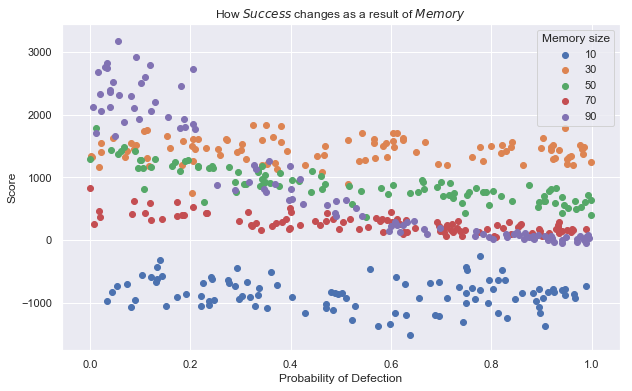

In [15]:
payoff_matrix = {'CC':3,'CD':-3,'DC':5,'DD':-5}
plt.figure(figsize = (10,6))
for m in [10,30,50,70,90]:
    sim = abm(N = 100, M = m, payoff = payoff_matrix)
    sim.world()
    result = sim.display()
    plt.scatter(result.pD, result.score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("How $Success$ changes as a result of $Memory$")